# BIDS Conversion Quality Check
This notebook verifies the quality of the ADNI4 to BIDS conversion by visualizing randomly selected data from different modalities.

In [3]:
import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import random
from pathlib import Path
from glob import glob
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Configuration
bids_root = Path('/home/mihirneal/Developer/adni2bids_1/BIDS_output_test')
print(f"BIDS root: {bids_root}")
print(f"Directory exists: {bids_root.exists()}")

BIDS root: /home/mihirneal/Developer/adni2bids_1/BIDS_output_test
Directory exists: True


## 1. Dataset Overview

In [4]:
# Get overview of converted data
subjects = sorted([d.name for d in bids_root.glob('sub-*') if d.is_dir()])
print(f"Total subjects: {len(subjects)}")
print(f"Subjects: {subjects}")

# Count sessions and files by modality
modalities = ['anat', 'func', 'dwi', 'fmap', 'perf']
stats = {}

for modality in modalities:
    files = list(bids_root.glob(f'**/{modality}/*.nii.gz'))
    sessions = list(bids_root.glob(f'**/ses-*/{modality}'))
    stats[modality] = {
        'files': len(files),
        'sessions': len(sessions),
        'example_files': [str(f.relative_to(bids_root)) for f in files[:3]]
    }

# Display stats
df_stats = pd.DataFrame(stats).T
print("\nModality Statistics:")
print(df_stats[['files', 'sessions']])

print("\nExample files per modality:")
for mod, data in stats.items():
    if data['files'] > 0:
        print(f"\n{mod.upper()}:")
        for example in data['example_files']:
            print(f"  {example}")

Total subjects: 6
Subjects: ['sub-127S2234', 'sub-127S6512', 'sub-135S5113', 'sub-137S4211', 'sub-168S6843', 'sub-381S10582']

Modality Statistics:
     files sessions
anat    85       36
func    14       14
dwi      3        3
fmap     0        0
perf     8        8

Example files per modality:

ANAT:
  sub-168S6843/ses-20200114/anat/sub-168S6843_ses-20200114_T1w.nii.gz
  sub-168S6843/ses-20200114/anat/sub-168S6843_ses-20200114_FLAIR.nii.gz
  sub-137S4211/ses-20121010/anat/sub-137S4211_ses-20121010_T1wa.nii.gz

FUNC:
  sub-168S6843/ses-20200114/func/sub-168S6843_ses-20200114_task-rest_bold.nii.gz
  sub-127S6512/ses-20220928/func/sub-127S6512_ses-20220928_task-rest_bold.nii.gz
  sub-127S6512/ses-20190926/func/sub-127S6512_ses-20190926_task-rest_bold.nii.gz

DWI:
  sub-127S6512/ses-20250318/dwi/sub-127S6512_ses-20250318_dwi.nii.gz
  sub-127S2234/ses-20250310/dwi/sub-127S2234_ses-20250310_dwi.nii.gz
  sub-135S5113/ses-20240717/dwi/sub-135S5113_ses-20240717_dwi.nii.gz

PERF:
  sub-137S421

## 2. File Selection for Quality Check

In [5]:
def get_random_files(bids_root, modality, n=2):
    """Get random files from a specific modality"""
    files = list(bids_root.glob(f'**/{modality}/*.nii.gz'))
    if len(files) == 0:
        return []
    return random.sample(files, min(n, len(files)))

# Select random files for each modality
selected_files = {}
for modality in modalities:
    files = get_random_files(bids_root, modality, n=2)
    if files:
        selected_files[modality] = files
        print(f"\n{modality.upper()} files selected:")
        for f in files:
            print(f"  {f.relative_to(bids_root)}")
    else:
        print(f"\n{modality.upper()}: No files found")


ANAT files selected:
  sub-135S5113/ses-20210713/anat/sub-135S5113_ses-20210713_T1w.nii.gz
  sub-381S10582/ses-20250320/anat/sub-381S10582_ses-20250320_T1w.nii.gz

FUNC files selected:
  sub-168S6843/ses-20200114/func/sub-168S6843_ses-20200114_task-rest_bold.nii.gz
  sub-135S5113/ses-20240717/func/sub-135S5113_ses-20240717_task-rest_bold.nii.gz

DWI files selected:
  sub-127S2234/ses-20250310/dwi/sub-127S2234_ses-20250310_dwi.nii.gz
  sub-127S6512/ses-20250318/dwi/sub-127S6512_ses-20250318_dwi.nii.gz

FMAP: No files found

PERF files selected:
  sub-137S4211/ses-20131011/perf/sub-137S4211_ses-20131011_asl.nii.gz
  sub-137S4211/ses-20120418/perf/sub-137S4211_ses-20120418_asl.nii.gz


## 3. BIDS Metadata Check

In [6]:
def check_bids_metadata(nii_file):
    """Check BIDS sidecar JSON metadata"""
    json_file = nii_file.with_suffix('.json')
    
    print(f"\nFile: {nii_file.name}")
    print(f"JSON sidecar exists: {json_file.exists()}")
    
    if json_file.exists():
        with open(json_file, 'r') as f:
            metadata = json.load(f)
        
        # Show key metadata fields
        key_fields = ['RepetitionTime', 'EchoTime', 'SliceThickness', 'PixelSpacing', 
                     'ImageOrientationPatient', 'MagneticFieldStrength', 'Manufacturer']
        
        print("Key metadata:")
        for field in key_fields:
            if field in metadata:
                value = metadata[field]
                if isinstance(value, list) and len(value) > 2:
                    print(f"  {field}: [{value[0]:.3f}, {value[1]:.3f}, ...]")
                else:
                    print(f"  {field}: {value}")
    
    return json_file.exists()

# Check metadata for selected files
print("BIDS Metadata Check:")
print("=" * 50)

for modality, files in selected_files.items():
    print(f"\n{modality.upper()} Metadata:")
    for f in files[:1]:  # Check first file of each modality
        check_bids_metadata(f)

BIDS Metadata Check:

ANAT Metadata:

File: sub-135S5113_ses-20210713_T1w.nii.gz
JSON sidecar exists: False

FUNC Metadata:

File: sub-168S6843_ses-20200114_task-rest_bold.nii.gz
JSON sidecar exists: False

DWI Metadata:

File: sub-127S2234_ses-20250310_dwi.nii.gz
JSON sidecar exists: False

PERF Metadata:

File: sub-137S4211_ses-20131011_asl.nii.gz
JSON sidecar exists: False


## 4. Image Data Visualization

In [7]:
def plot_image_slices(nii_file, title=None, n_slices=5):
    """Plot middle slices of a NIfTI image"""
    try:
        img = nib.load(nii_file)
        data = img.get_fdata()
        
        if title is None:
            title = nii_file.name
        
        print(f"\nImage: {title}")
        print(f"Shape: {data.shape}")
        print(f"Data type: {data.dtype}")
        print(f"Value range: [{data.min():.2f}, {data.max():.2f}]")
        print(f"Voxel size: {img.header.get_zooms()[:3]}")
        
        # For 4D data (fMRI, DWI), take middle volume
        if len(data.shape) == 4:
            print(f"4D data - using volume {data.shape[3]//2} of {data.shape[3]}")
            data = data[:, :, :, data.shape[3]//2]
        
        # Plot middle slices in different orientations
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        fig.suptitle(title, fontsize=14)
        
        # Axial (z-axis)
        z_slice = data.shape[2] // 2
        axes[0].imshow(data[:, :, z_slice].T, cmap='gray', origin='lower')
        axes[0].set_title(f'Axial (z={z_slice})')
        axes[0].axis('off')
        
        # Sagittal (x-axis)
        x_slice = data.shape[0] // 2
        axes[1].imshow(data[x_slice, :, :].T, cmap='gray', origin='lower')
        axes[1].set_title(f'Sagittal (x={x_slice})')
        axes[1].axis('off')
        
        # Coronal (y-axis)
        y_slice = data.shape[1] // 2
        axes[2].imshow(data[:, y_slice, :].T, cmap='gray', origin='lower')
        axes[2].set_title(f'Coronal (y={y_slice})')
        axes[2].axis('off')
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error loading {nii_file}: {e}")

print("Image Visualization:")
print("=" * 50)

Image Visualization:


### 4.1 Anatomical Images (T1w, FLAIR)

ANATOMICAL IMAGES

Image: sub-135S5113_ses-20210713_T1w.nii.gz
Shape: (196, 256, 256)
Data type: float64
Value range: [0.00, 6545.00]
Voxel size: (np.float32(1.0), np.float32(1.0), np.float32(1.0))


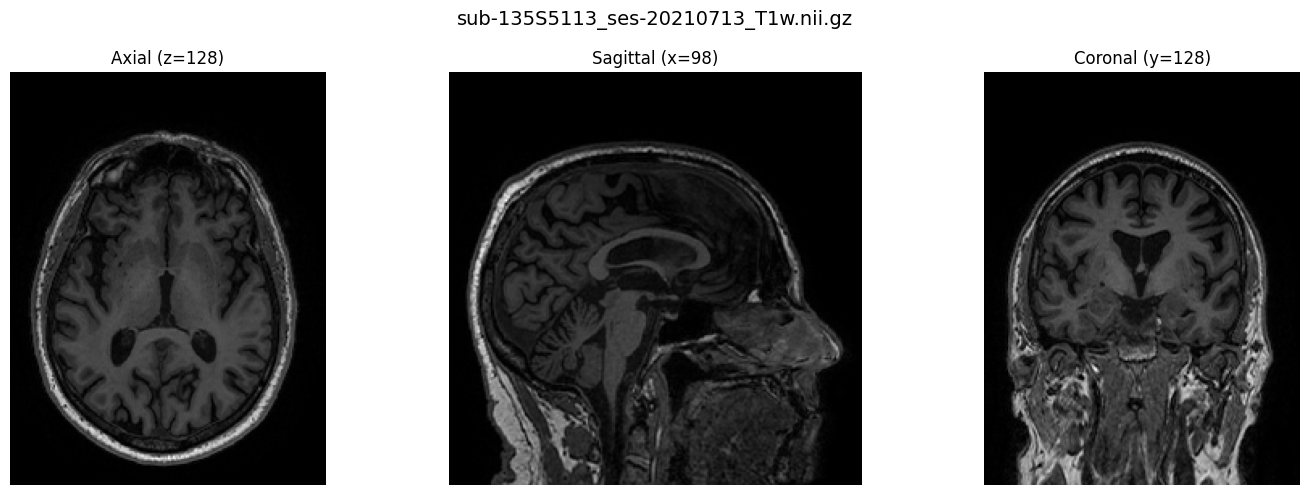


Image: sub-381S10582_ses-20250320_T1w.nii.gz
Shape: (208, 240, 256)
Data type: float64
Value range: [0.00, 662.00]
Voxel size: (np.float32(1.0), np.float32(1.0), np.float32(1.0))


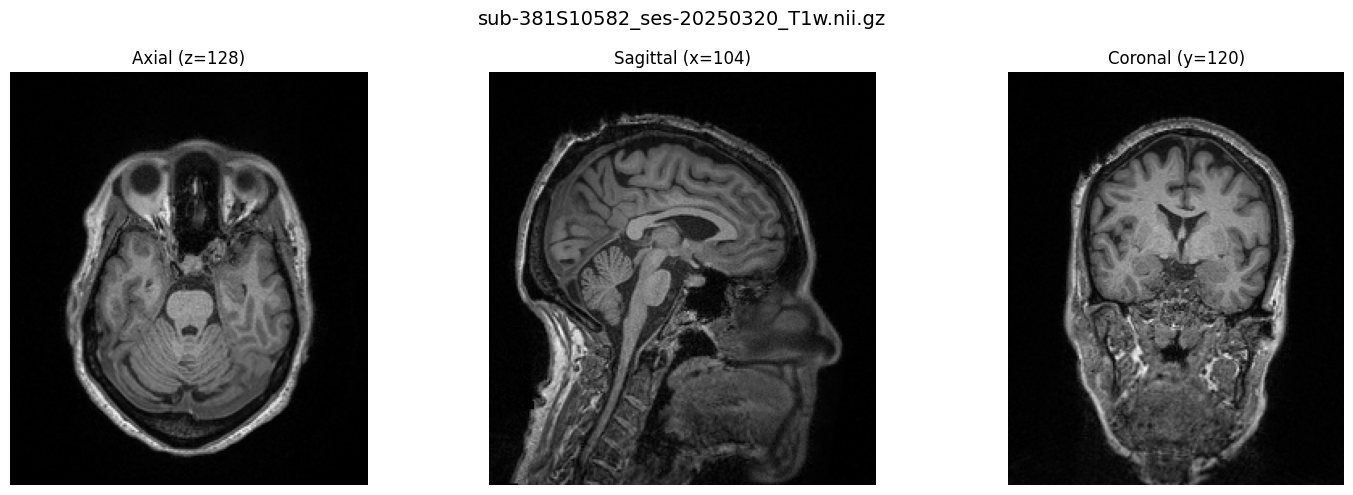

In [8]:
if 'anat' in selected_files:
    print("ANATOMICAL IMAGES")
    print("=" * 30)
    
    for anat_file in selected_files['anat']:
        plot_image_slices(anat_file)

### 4.2 Functional Images (task-rest_bold)

FUNCTIONAL IMAGES

Image: sub-168S6843_ses-20200114_task-rest_bold.nii.gz
Shape: (64, 64, 48, 197)
Data type: float64
Value range: [0.00, 2426.00]
Voxel size: (np.float32(3.4375), np.float32(3.4375), np.float32(3.3999999))
4D data - using volume 98 of 197


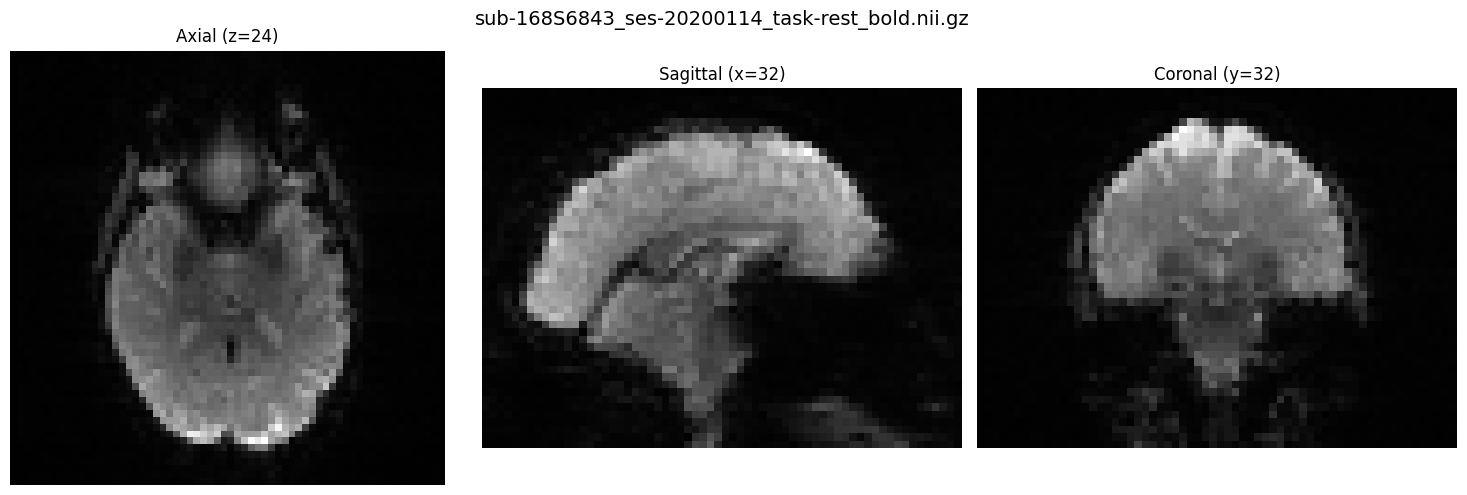


fMRI Time Series Analysis:
Time points: 197


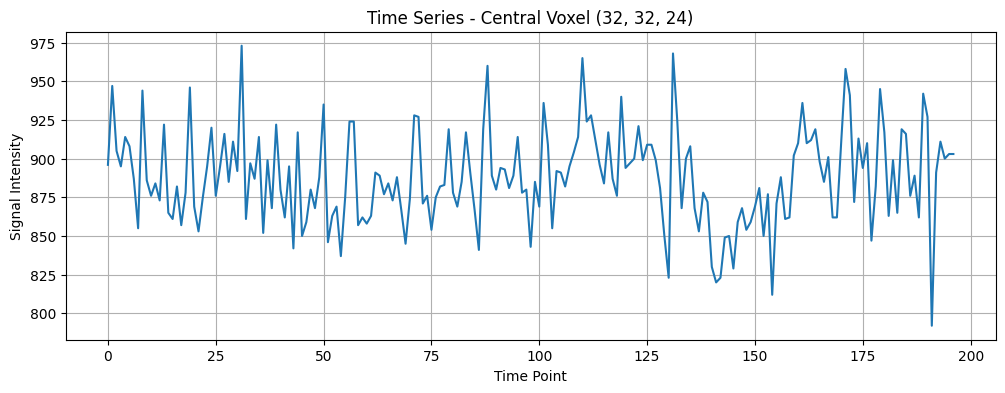


Image: sub-135S5113_ses-20240717_task-rest_bold.nii.gz
Shape: (64, 64, 48, 200)
Data type: float64
Value range: [0.00, 11032.00]
Voxel size: (np.float32(3.4375), np.float32(3.4375), np.float32(3.4))
4D data - using volume 100 of 200


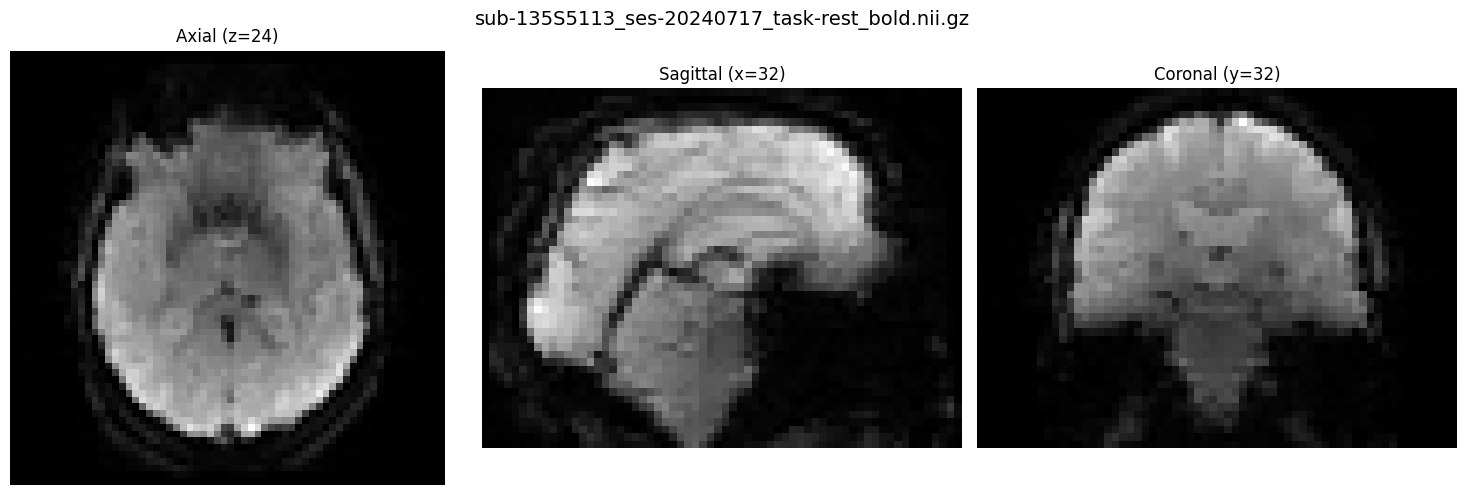


fMRI Time Series Analysis:
Time points: 200


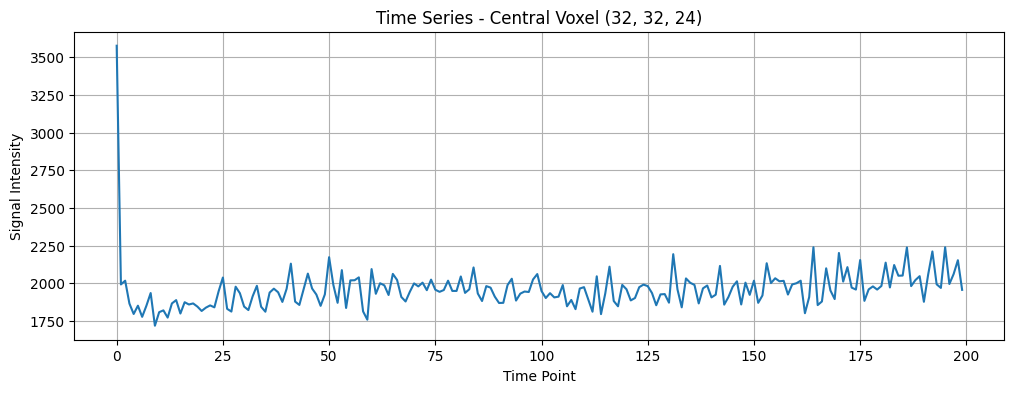

In [9]:
if 'func' in selected_files:
    print("FUNCTIONAL IMAGES")
    print("=" * 30)
    
    for func_file in selected_files['func']:
        plot_image_slices(func_file)
        
        # Additional fMRI-specific analysis
        try:
            img = nib.load(func_file)
            data = img.get_fdata()
            if len(data.shape) == 4:
                print(f"\nfMRI Time Series Analysis:")
                print(f"Time points: {data.shape[3]}")
                
                # Plot mean signal over time for a central voxel
                center = [s//2 for s in data.shape[:3]]
                voxel_signal = data[center[0], center[1], center[2], :]
                
                plt.figure(figsize=(12, 4))
                plt.plot(voxel_signal)
                plt.title(f'Time Series - Central Voxel ({center[0]}, {center[1]}, {center[2]})')
                plt.xlabel('Time Point')
                plt.ylabel('Signal Intensity')
                plt.grid(True)
                plt.show()
        except Exception as e:
            print(f"Error in fMRI analysis: {e}")

### 4.3 Diffusion Images (DWI)

DIFFUSION IMAGES

Image: sub-127S2234_ses-20250310_dwi.nii.gz
Shape: (256, 256, 81, 127)
Data type: float64
Value range: [0.00, 6948.00]
Voxel size: (np.float32(0.9063), np.float32(0.9063), np.float32(2.0))
4D data - using volume 63 of 127


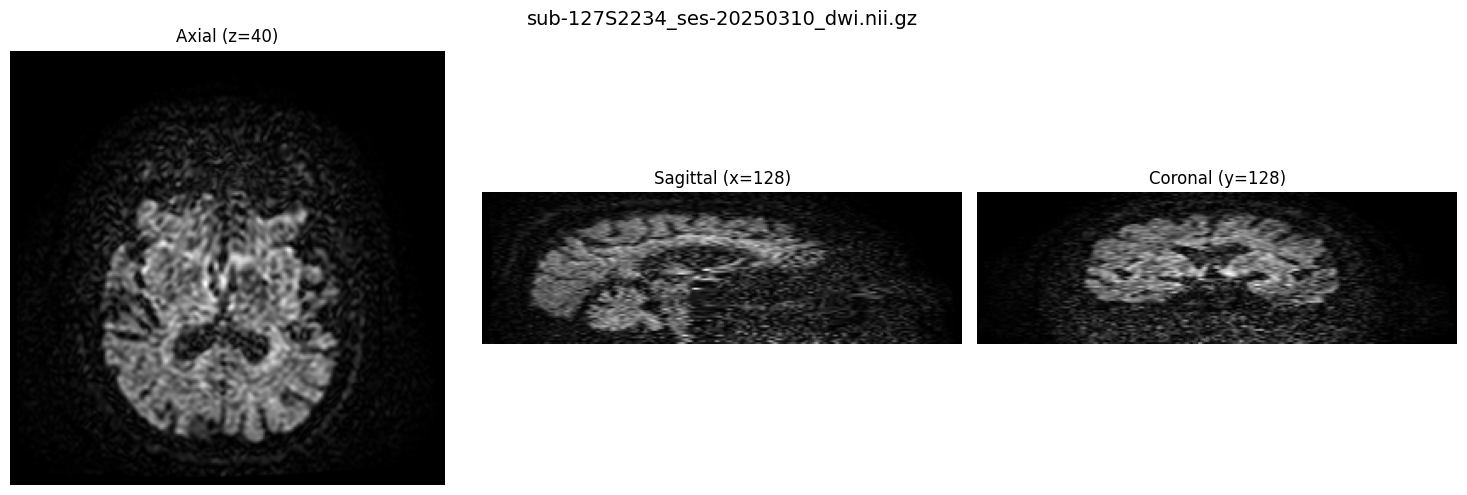


DWI Analysis:
Diffusion directions: 127
bval file exists: False
bvec file exists: False


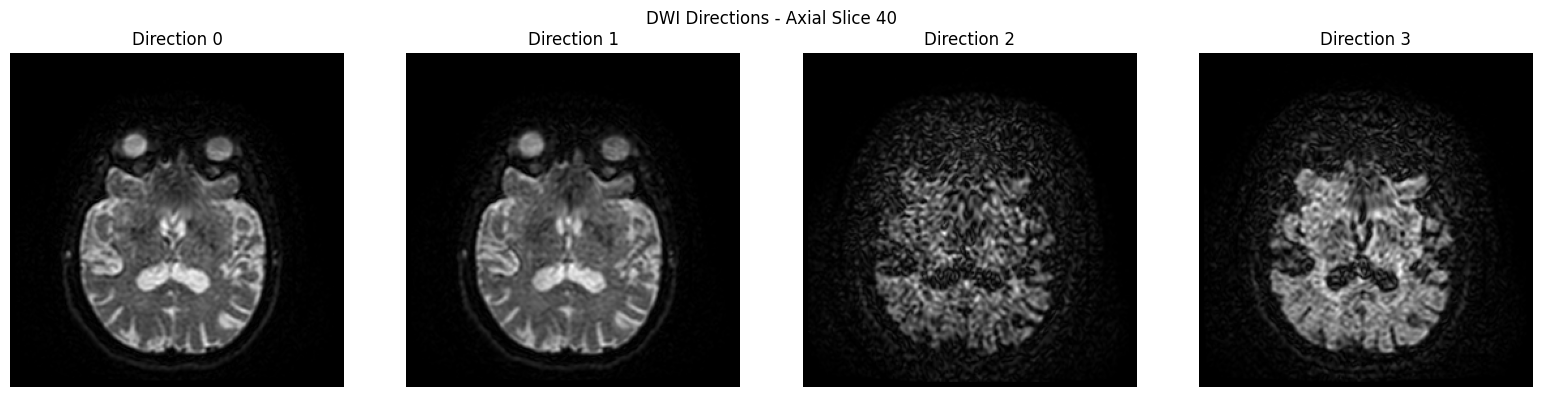


Image: sub-127S6512_ses-20250318_dwi.nii.gz
Shape: (256, 256, 81, 127)
Data type: float64
Value range: [0.00, 7022.00]
Voxel size: (np.float32(0.9063), np.float32(0.9063), np.float32(2.0))
4D data - using volume 63 of 127


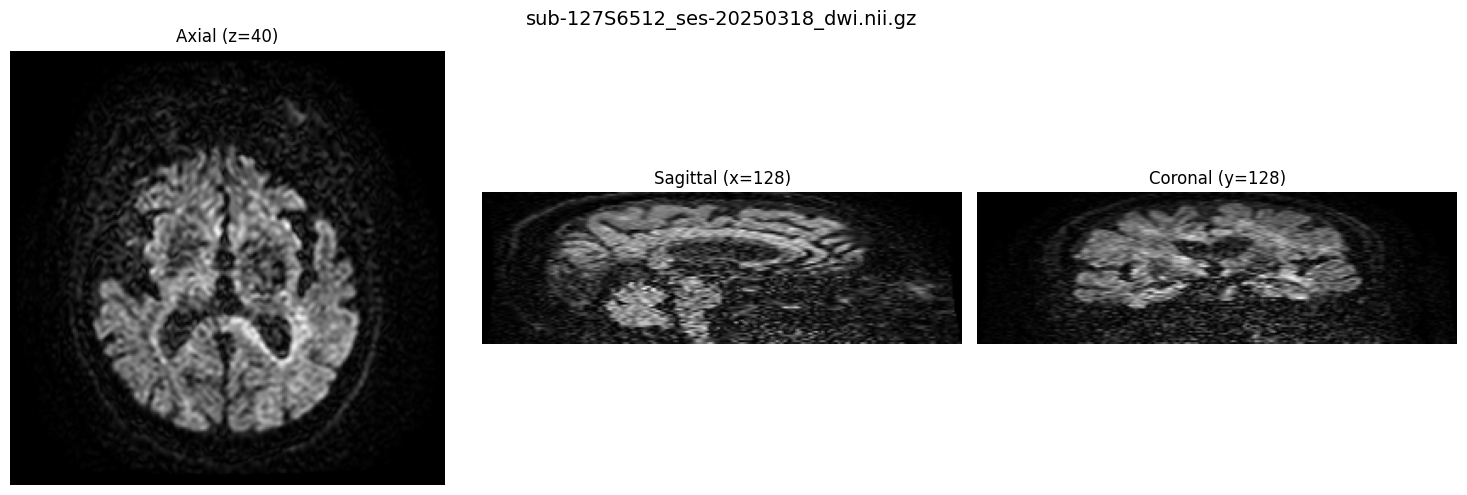


DWI Analysis:
Diffusion directions: 127
bval file exists: False
bvec file exists: False


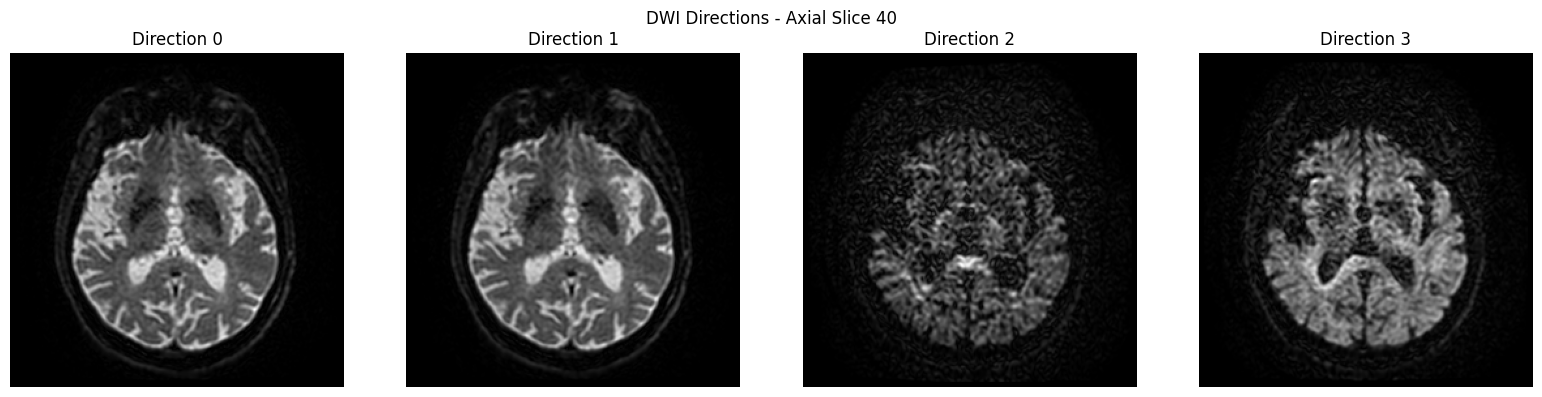

In [10]:
if 'dwi' in selected_files:
    print("DIFFUSION IMAGES")
    print("=" * 30)
    
    for dwi_file in selected_files['dwi']:
        plot_image_slices(dwi_file)
        
        # DWI-specific analysis
        try:
            img = nib.load(dwi_file)
            data = img.get_fdata()
            if len(data.shape) == 4:
                print(f"\nDWI Analysis:")
                print(f"Diffusion directions: {data.shape[3]}")
                
                # Check for corresponding .bval and .bvec files
                bval_file = dwi_file.with_suffix('.bval')
                bvec_file = dwi_file.with_suffix('.bvec')
                
                print(f"bval file exists: {bval_file.exists()}")
                print(f"bvec file exists: {bvec_file.exists()}")
                
                if bval_file.exists():
                    bvals = np.loadtxt(bval_file)
                    print(f"B-values: {len(bvals)} values, range: [{bvals.min()}, {bvals.max()}]")
                    unique_bvals = np.unique(bvals)
                    print(f"Unique b-values: {unique_bvals}")
                    
                # Show different diffusion directions
                if data.shape[3] > 1:
                    fig, axes = plt.subplots(1, min(4, data.shape[3]), figsize=(16, 4))
                    if data.shape[3] == 1:
                        axes = [axes]
                    
                    z_slice = data.shape[2] // 2
                    for i, ax in enumerate(axes):
                        if i < data.shape[3]:
                            ax.imshow(data[:, :, z_slice, i].T, cmap='gray', origin='lower')
                            ax.set_title(f'Direction {i}')
                            ax.axis('off')
                    
                    plt.suptitle(f'DWI Directions - Axial Slice {z_slice}')
                    plt.tight_layout()
                    plt.show()
                    
        except Exception as e:
            print(f"Error in DWI analysis: {e}")

### 4.4 Fieldmap Images

In [11]:
if 'fmap' in selected_files:
    print("FIELDMAP IMAGES")
    print("=" * 30)
    
    for fmap_file in selected_files['fmap']:
        plot_image_slices(fmap_file)

### 4.5 Perfusion Images

PERFUSION IMAGES

Image: sub-137S4211_ses-20131011_asl.nii.gz
Shape: (64, 64, 24)
Data type: float64
Value range: [-4096.00, 1846.73]
Voxel size: (np.float32(3.75), np.float32(3.75), np.float32(5.0))


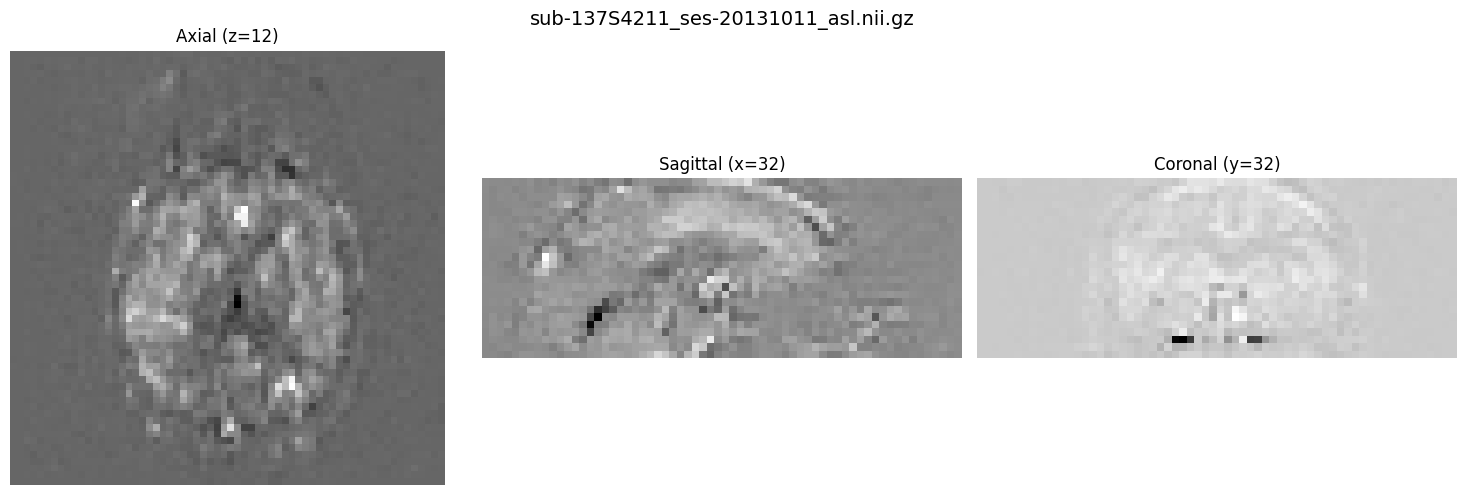


Image: sub-137S4211_ses-20120418_asl.nii.gz
Shape: (64, 64, 24)
Data type: float64
Value range: [-3381.91, 4095.00]
Voxel size: (np.float32(3.75), np.float32(3.75), np.float32(5.0))


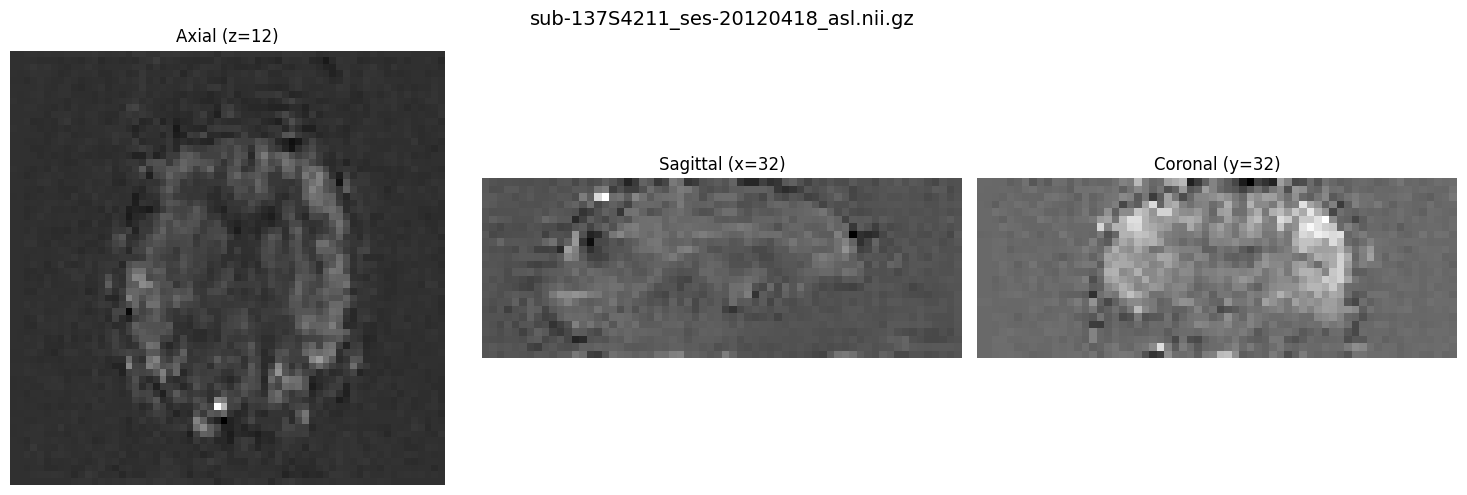

In [12]:
if 'perf' in selected_files:
    print("PERFUSION IMAGES")
    print("=" * 30)
    
    for perf_file in selected_files['perf']:
        plot_image_slices(perf_file)

## 5. BIDS Validation Summary

In [ ]:
def validate_bids_structure(bids_root):
    """Basic BIDS structure validation"""
    issues = []
    
    # Check for required files
    dataset_desc = bids_root / 'dataset_description.json'
    if not dataset_desc.exists():
        issues.append("Missing dataset_description.json")
    
    # Check subject naming
    subjects = list(bids_root.glob('sub-*'))
    for sub_dir in subjects:
        if not sub_dir.name.startswith('sub-'):
            issues.append(f"Invalid subject naming: {sub_dir.name}")
    
    # Check for orphaned files (NIfTI without JSON)
    nii_files = list(bids_root.glob('**/*.nii.gz'))
    for nii_file in nii_files:
        json_file = nii_file.with_suffix('.json')
        if not json_file.exists():
            issues.append(f"Missing JSON sidecar: {nii_file.relative_to(bids_root)}")
    
    return issues

print("BIDS Validation Summary:")
print("=" * 50)

issues = validate_bids_structure(bids_root)

if issues:
    print(f"Found {len(issues)} issues:")
    for issue in issues[:10]:  # Show first 10 issues
        print(f"  - {issue}")
    if len(issues) > 10:
        print(f"  ... and {len(issues) - 10} more issues")
else:
    print("Basic BIDS structure validation passed!")

# Summary statistics
print(f"\nDataset Summary:")
print(f"Subjects: {len(subjects)}")
total_sessions = len(list(bids_root.glob('**/ses-*')))
total_nii = len(list(bids_root.glob('**/*.nii.gz')))
total_json = len(list(bids_root.glob('**/*.json')))

print(f"Sessions: {total_sessions}")
print(f"NIfTI files: {total_nii}")
print(f"JSON files: {total_json}")
print(f"JSON coverage: {total_json/total_nii*100:.1f}%")

## 6. Recommendations

Based on this quality check:

1. **Images should be properly oriented** and show expected anatomy
2. **Metadata should include key DICOM fields** like TR, TE, etc.
3. **File naming should follow BIDS conventions**
4. **Each NIfTI should have a corresponding JSON sidecar**
5. **4D data (fMRI, DWI) should have expected dimensions**

If any images appear corrupted, have wrong orientations, or are missing metadata, investigate the dcm2niix conversion process.